In [ ]:
#import all the necessary libraries: pandsas, numpy, matplotlib, votekit (If not, downolad it via pip install <library>)


import pandas as pd
import numpy as np
import Voting_rules
import fairness_metric
import os
from votekit import pref_profile
from votekit.elections import Borda, Plurality, STV
import matplotlib.pyplot as plt
from votekit.cvr_loaders import load_scottish
from fairness_metric import sigma_IIA, sigma_UF, sigma_IIA_STV, sigma_UF_STV
from Voting_rules import Ranked_Borda, Ranked_Plurality, Ranked_2_Approval,Ranked_3_Approval
from votekit.cvr_loaders import load_scottish  # your load function for Scottish profiles
import matplotlib.patches as mpatches
import re
from tqdm import tqdm


#This script computes the fairness metrics for the Scottish election data using voting rules: Plurality, Borda, 2-Approval, and 3-Approval. Note that for the STV there is a separate script.

np.random.seed(2025)  # For reproducibility as ties are broken randomly (though ties are rare in the scottish data)

# make sure to install the required libraries if you haven't already

#  Define base path 
base_path = '/Users/name/Downloads/scot-elex-main' #scottish data path

#  Define all voting rules and labels 
voting_rules = {
    "Plurality": Ranked_Plurality,
    "Borda": Ranked_Borda,
    "2-Approval": Ranked_2_Approval,
    "3-Approval": Ranked_3_Approval
}

# Helper: parse council, year, ward from filename 
def split_file_name(file_name):
    parts = file_name.replace(".csv", "").split("_")
    council_words = []

    for i, part in enumerate(parts):
        if re.match(r"\d{4}", part):  # year pattern
            year = part
            council = "_".join(council_words)
            ward = "_".join(parts[i+1:])
            return council, int(year), ward
        else:
            council_words.append(part)

    # fallback
    return "_".join(parts[:-2]), int(parts[-2]), parts[-1]

# Main processing 
records = []

for num_cands in range(3, 15):
    folder_path = os.path.join(base_path, f"{num_cands}_cands")
    if not os.path.exists(folder_path):
        print(f"Skipping missing folder: {folder_path}")
        continue

    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    for file in tqdm(files, desc=f"{num_cands} candidates", leave=False):
        try:
            full_path = os.path.join(folder_path, file)
            profile, seats, cand_list, cand_to_party, _ = load_scottish(full_path)
            council, year, ward = split_file_name(file)

            result = {
                "Council": council,
                "Year": year,
                "Ward": ward,
                "Num_Candidates": num_cands,
                "Num_seats": seats,
            }

            # Compute and store metrics for each rule
            for rule_name, rule_func in voting_rules.items():
                try:
                    result[f"Sigma_IIA_{rule_name}"] = round(float(sigma_IIA(profile, rule_func)),4)
                except Exception as e:
                    print(f"IIA error in {file} ({rule_name}): {e}")
                    result[f"Sigma_IIA_{rule_name}"] = None

                try:
                    result[f"Sigma_UF_{rule_name}"] = round(float(sigma_UF(profile, rule_func)),4)
                except Exception as e:
                    print(f"UF error in {file} ({rule_name}): {e}")
                    result[f"Sigma_UF_{rule_name}"] = None

            result["File"] = file.replace(".csv", "")
            records.append(result)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

#  Create and save final DataFrame 
df = pd.DataFrame(records)

# reorder columns for readability
ordered_cols = [
    "Council", "Year", "Ward", "Num_Candidates", "Num_seats",
    "Sigma_IIA_Plurality", "Sigma_IIA_Borda", "Sigma_IIA_2-Approval", "Sigma_IIA_3-Approval",
    "Sigma_UF_Plurality", "Sigma_UF_Borda", "Sigma_UF_2-Approval", "Sigma_UF_3-Approval",
    "File"
]
df = df[ordered_cols]

# Save output 
output_path = "/Users/name/Downloads/fairness_scottish_complete_results.csv"  # specify your output path
df.to_csv(output_path, index=False)
print(f"\n Results saved to: {output_path}")

In [ ]:

#Code for cleaning up the council names
output_path = "/Users/name/Downloads/fairness_scottish_complete_results.csv" #specify your you saved output path of the above code

df = pd.read_csv(output_path)

council_name_map = {
    'eilean_siar': "Na h-Eileanan Siar",
    'stirling': "Stirling",
    'sc_borders': "Scottish Borders",
    'east_dunbartonshire': "East Dunbartonshire",
    'moray': "Moray",
    'north_lanarkshire': "North Lanarkshire",
    'shetland': "Shetland Islands",
    'argyll_bute': "Argyll and Bute",
    'south_ayrshire': "South Ayrshire",
    'south_lanarkshire': "South Lanarkshire",
    'aberdeenshire': "Aberdeenshire",
    'highland': "Highland",
    'midlothian': "Midlothian",
    'angus': "Angus",
    'orkney': "Orkney Islands",
    'aberdeen': "Aberdeen City",
    'clackmannanshire': "Clackmannanshire",
    'dumgal': "Dumfries and Galloway",
    'east_ayrshire': "East Ayrshire",
    'falkirk': "Falkirk",
    'inverclyde': "Inverclyde",
    'edinburgh': "City of Edinburgh",
    'fife': "Fife",
    'perth_kinross': "Perth and Kinross",
    'east_renfrewshire': "East Renfrewshire",
    'renfrewshire': "Renfrewshire",
    'west_dunbartonshire': "West Dunbartonshire",
    'east_lothian': "East Lothian",
    'west_lothian': "West Lothian",
    'north_ayrshire': "North Ayrshire",
    'dundee': "Dundee City",
    'glasgow': "Glasgow City"
}

# Filter to keep only valid councils
filtered_df = df[df["Council"].isin(council_name_map.keys())].copy()

# Replace council codes with proper names
filtered_df["Council"] = filtered_df["Council"].map(council_name_map)

# Drop the display and file name if they exist
cols_to_drop = [col for col in ["Council_Display", "File"] if col in filtered_df.columns]
filtered_df.drop(columns=cols_to_drop, inplace=True)


# Final output
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.head()

# Save the cleaned DataFrame
output_path_cleaned = "/Users/ss2776/Downloads/fairness_scottish_cleaned_results_Borda_Plurality_2_3_approval.csv"
filtered_df.to_csv(output_path_cleaned,index=False)  # specify your output path

filtered_df.head()

,Council,Year,Ward,Num_Candidates,Num_seats,Sigma_IIA_Plurality,Sigma_IIA_Borda,Sigma_IIA_2-Approval,Sigma_IIA_3-Approval,Sigma_UF_Plurality,Sigma_UF_Borda,Sigma_UF_2-Approval,Sigma_UF_3-Approval
0,Na h-Eileanan Siar,2022,ward3,3,2,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0000
1,Na h-Eileanan Siar,2022,ward4,3,2,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0000
2,Stirling,2012,ward5,4,3,1.0,1.0,0.8333,0.8333,1.0,1.0,1.0,0.9231
3,Scottish Borders,2017,ward11,4,3,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0000
4,East Dunbartonshire,2012,ward1,4,3,1.0,1.0,1.0000,1.0000,1.0,1.0,1.0,1.0000


In [ ]:
#This script computes the fairness metrics for the Scottish election data using the Ranked STV voting rule.
#Note that we used an entire separte script for STV 

from Voting_rules import Ranked_STV
from tqdm import tqdm
import os
import re

import numpy as np

np.random.seed(2025) # For reproducibility as ties are broken randomly (though ties are rare in the scottish data)



# 1. Base path and helper functions

base_path = '/Users/ss2776/Downloads/scot-elex-main' # scottish data path

# Helper: parse council, year, ward from filename ===
def split_file_name(file_name):
    parts = file_name.replace(".csv", "").split("_")
    council_words = []

    for i, part in enumerate(parts):
        if re.match(r"\d{4}", part):  # year pattern
            year = part
            council = "_".join(council_words)
            ward = "_".join(parts[i+1:])
            return council, int(year), ward
        else:
            council_words.append(part)

    # fallback
    return "_".join(parts[:-2]), int(parts[-2]), parts[-1]


# 2. Storage for results
records = []

# 3. Loop over folders 3_cands to 14_cands
for num_cands in range(3, 15):
    folder_path = os.path.join(base_path, f"{num_cands}_cands")
    
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist, skipping.")
        continue

    files = os.listdir(folder_path)

    
    
    for file in tqdm(files, desc=f"{num_cands} candidates", leave=False):
        if file.endswith('.csv'):
            try:
                full_path = os.path.join(folder_path, file)
                
                # Load election profile
                scottish_profile, seats, cand_list, cand_to_party, ward = load_scottish(full_path)
                council, year, ward = split_file_name(file)
                
                # Compute σIIA metrics
                sigma_iia_stv = sigma_IIA_STV(scottish_profile, seats, Ranked_STV)
                # Compute σUF metrics
                sigma_uf_stv = sigma_UF_STV(scottish_profile, seats, Ranked_STV)
                
                # Record the results
                records.append({
                    "Council": council,
                    "Year": year,
                    "Ward": ward,
                    "Num_Candidates": num_cands,
                    "Num_seats": seats,
                    "Sigma_IIA_STV": sigma_iia_stv,
                    "Sigma_UF_STV": sigma_uf_stv,
                    
                })
                
               
            
            except Exception as e:
                print(f"Error processing {file}: {e}")

# 4. Create results DataFrame
results_df = pd.DataFrame(records)

# 5. Save results to Downloads
results_csv_path = "/Users/ss2776/Downloads/full_scottish_stv_experiment_results.csv" # specify your output path
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to: {results_csv_path}")

In [ ]:
# Code for cleaning up the council names

df = pd.read_csv('/Users/ss2776/Downloads/full_scottish_stv_experiment_results.csv') #specify your you saved output path of the above code
council_name_map = {
    'eilean_siar': "Na h-Eileanan Siar",
    'stirling': "Stirling",
    'sc_borders': "Scottish Borders",
    'east_dunbartonshire': "East Dunbartonshire",
    'moray': "Moray",
    'north_lanarkshire': "North Lanarkshire",
    'shetland': "Shetland Islands",
    'argyll_bute': "Argyll and Bute",
    'south_ayrshire': "South Ayrshire",
    'south_lanarkshire': "South Lanarkshire",
    'aberdeenshire': "Aberdeenshire",
    'highland': "Highland",
    'midlothian': "Midlothian",
    'angus': "Angus",
    'orkney': "Orkney Islands",
    'aberdeen': "Aberdeen City",
    'clackmannanshire': "Clackmannanshire",
    'dumgal': "Dumfries and Galloway",
    'east_ayrshire': "East Ayrshire",
    'falkirk': "Falkirk",
    'inverclyde': "Inverclyde",
    'edinburgh': "City of Edinburgh",
    'fife': "Fife",
    'perth_kinross': "Perth and Kinross",
    'east_renfrewshire': "East Renfrewshire",
    'renfrewshire': "Renfrewshire",
    'west_dunbartonshire': "West Dunbartonshire",
    'east_lothian': "East Lothian",
    'west_lothian': "West Lothian",
    'north_ayrshire': "North Ayrshire",
    'dundee': "Dundee City",
    'glasgow': "Glasgow City"
}

# Filter to keep only valid councils
filtered_df = df[df["Council"].isin(council_name_map.keys())].copy()

# Replace council codes with proper names
filtered_df["Council"] = filtered_df["Council"].map(council_name_map)

# Drop the display and file name if they exist
cols_to_drop = [col for col in ["Council_Display", "File"] if col in filtered_df.columns]
filtered_df.drop(columns=cols_to_drop, inplace=True)

# Final output
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.head(78)

# Save the cleaned DataFrame
output_path_cleaned = "/Users/name/Downloads/fairness_scottish_cleaned_results_STV.csv"  # specify your output path
filtered_df.to_csv(output_path_cleaned, index=False)

filtered_df.head(78)

,Council,Year,Ward,Num_Candidates,Num_seats,Sigma_IIA_STV,Sigma_UF_STV
0,Na h-Eileanan Siar,2022,ward3,3,2,1.000000,1.000000
1,Na h-Eileanan Siar,2022,ward4,3,2,1.000000,1.000000
2,Stirling,2012,ward5,4,3,1.000000,1.000000
3,Scottish Borders,2017,ward11,4,3,1.000000,1.000000
4,East Dunbartonshire,2012,ward1,4,3,1.000000,1.000000
...,...,...,...,...,...,...,...
73,Midlothian,2012,ward6,5,3,0.866667,1.000000
74,North Lanarkshire,2012,ward10,5,3,0.933333,1.000000
75,Orkney Islands,2022,ward6,5,3,1.000000,0.969378
76,Dumfries and Galloway,2017,ward11,5,4,1.000000,0.907252


In [ ]:
 #After we have ran the above, we combine the two separarte dataframe into a single one.
#Code for combining the two dataframes


df1 = pd.read_csv('/Users/name/Downloads/fairness_scottish_cleaned_results_Borda_Plurality_2_3_approval.csv') #specify the path for the csv file of plurality, Borda, 2-Approval, and 3-Approval
df2 = pd.read_csv('/Users/name/Downloads/fairness_scottish_cleaned_results_STV.csv') #specify the path for the csv file of STV
common_cols = ['Council', 'Year', 'Ward', 'Num_Candidates', 'Num_seats']
df_combined = pd.concat([df1, df2.drop(columns=common_cols)], axis=1)
df_combined

# Save the combined DataFrame
output_path_combined = "/Users/name/Downloads/fairness_scottish_combined_results.csv"  # specify your output path
df_combined.to_csv(output_path_combined, index=False)

#this is the final output which contains the fairness metrics for all the voting rules and we will use this for the analysis and plotting
  

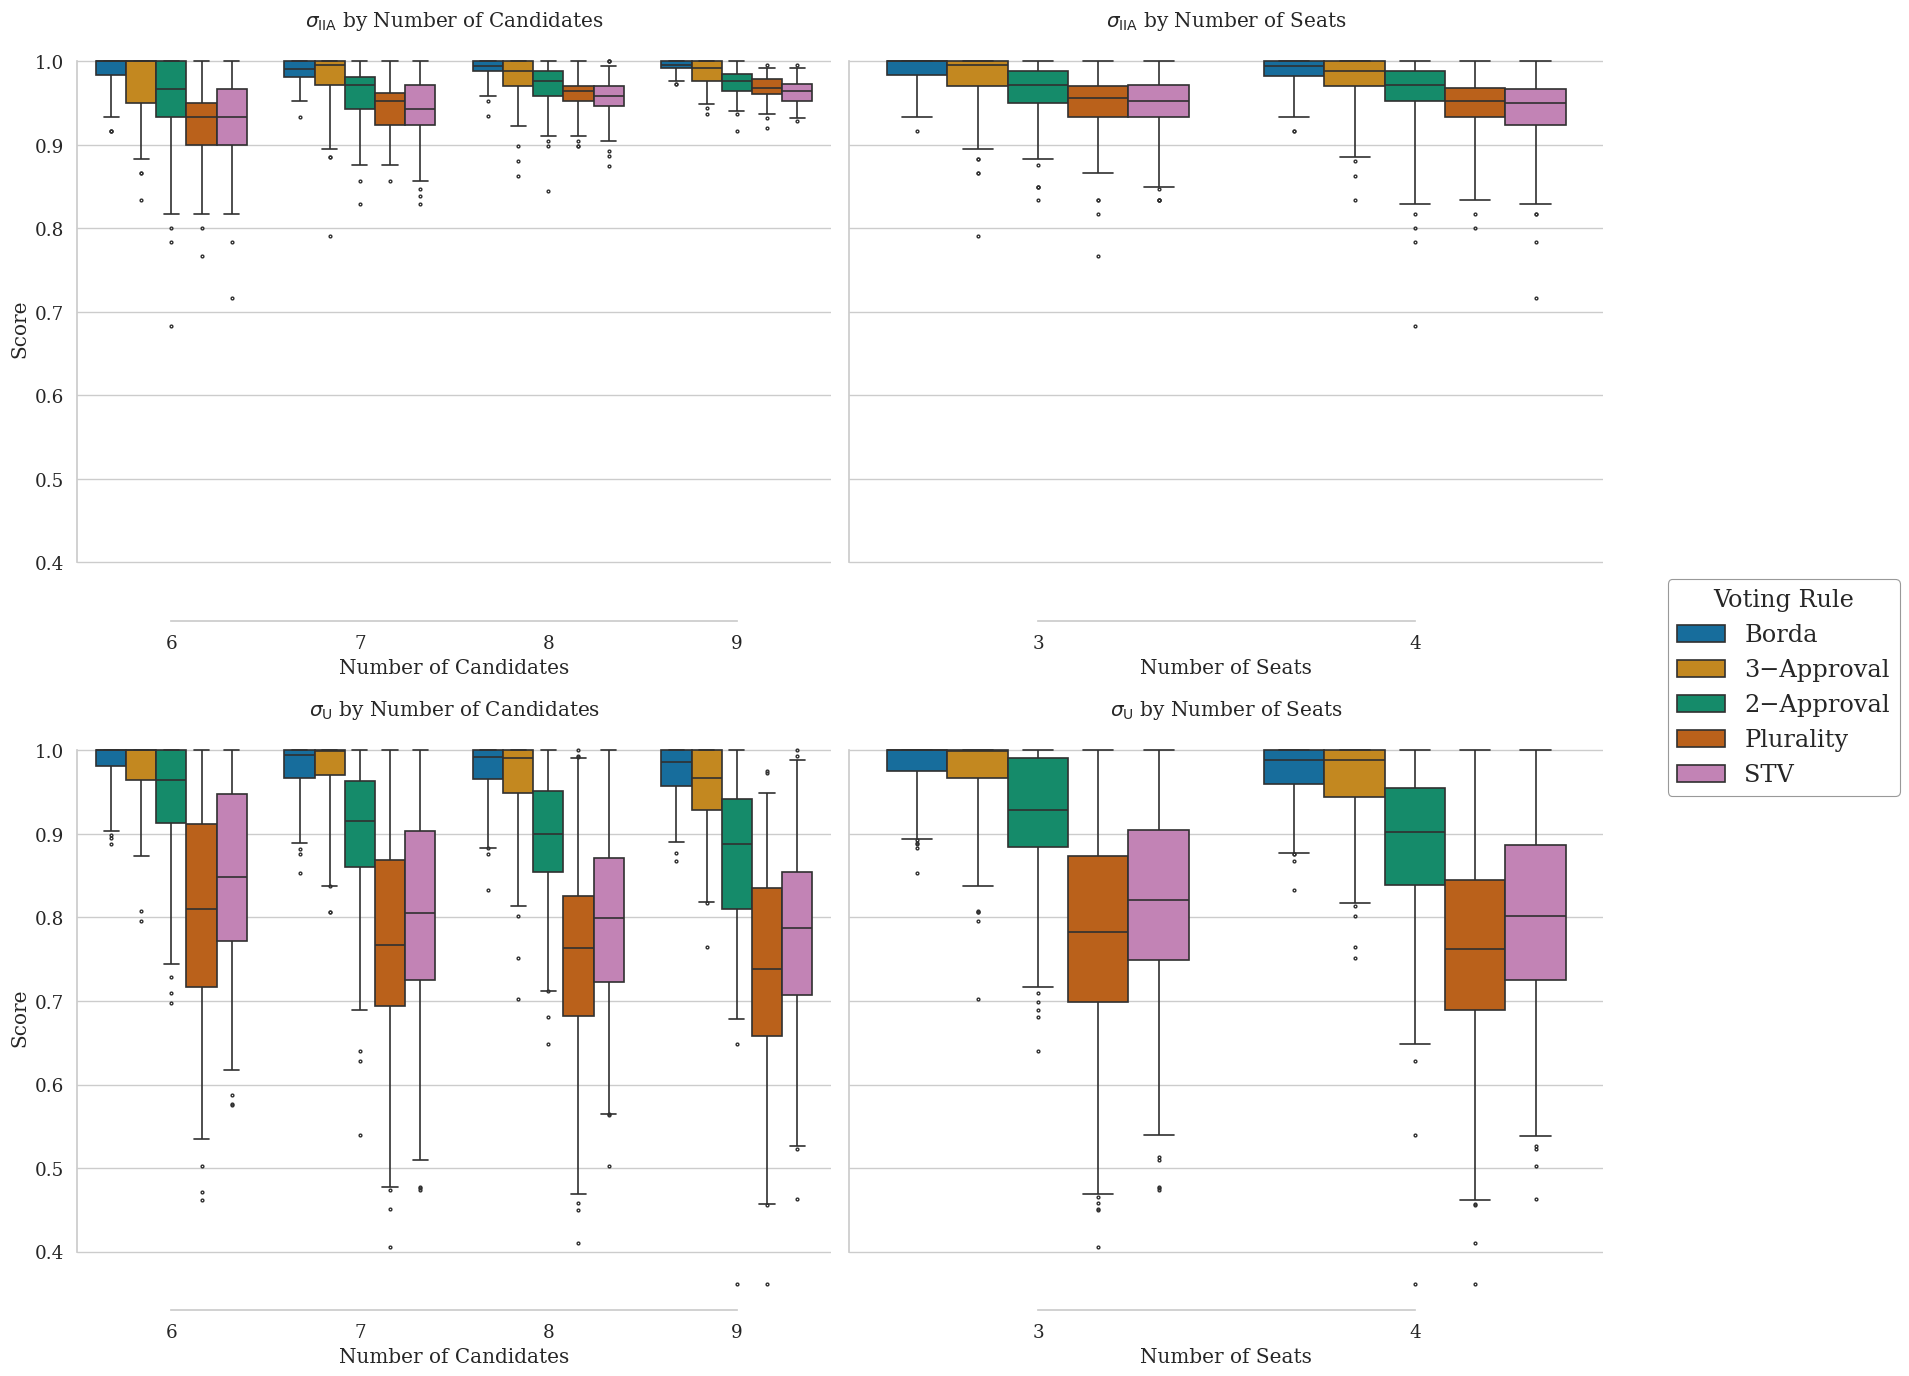

In [ ]:
#Code for generating the boxplot of IIA and UF (across voting rules) by number of candidates and number of seats in the scottish dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your local CSV file
df = pd.read_csv('/Users/ss2776/name/fairness_scottish_combined_results.csv') #specify the path for the combined dataframe

# Filter the dataset
df_subset = df[df["Num_Candidates"].isin([6, 7, 8, 9]) & df["Num_seats"].isin([3, 4])]

# Voting rule order and mapping
ordered_rules = ['Borda', '3−Approval', '2−Approval', 'Plurality', 'STV']
iia_col_map = {
    'Sigma_IIA_Borda': 'Borda',
    'Sigma_IIA_3-Approval': '3−Approval',
    'Sigma_IIA_2-Approval': '2−Approval',
    'Sigma_IIA_Plurality': 'Plurality',
    'Sigma_IIA_STV': 'STV'
}
uf_col_map = {
    'Sigma_UF_Borda': 'Borda',
    'Sigma_UF_3-Approval': '3−Approval',
    'Sigma_UF_2-Approval': '2−Approval',
    'Sigma_UF_Plurality': 'Plurality',
    'Sigma_UF_STV': 'STV'
}

# Melt helper
def melt_df(metric_cols, id_var, value_name, label, col_map):
    df_melted = df_subset[metric_cols + [id_var]].melt(
        id_vars=[id_var],
        var_name="Voting Rule Raw",
        value_name="Score"
    )
    df_melted["Voting Rule"] = df_melted["Voting Rule Raw"].map(col_map)
    df_melted["Metric"] = label
    df_melted["X"] = df_melted[id_var]
    return df_melted

# Create the four datasets
df_iia_cands = melt_df(list(iia_col_map.keys()), 'Num_Candidates', 'Score', r"$\sigma_{\mathrm{IIA}}$", iia_col_map)
df_uf_cands = melt_df(list(uf_col_map.keys()), 'Num_Candidates', 'Score', r"$\sigma_{\mathrm{U}}$", uf_col_map)
df_iia_seats = melt_df(list(iia_col_map.keys()), 'Num_seats', 'Score', r"$\sigma_{\mathrm{IIA}}$", iia_col_map)
df_uf_seats = melt_df(list(uf_col_map.keys()), 'Num_seats', 'Score', r"$\sigma_{\mathrm{U}}$", uf_col_map)

# Combine all into one dataframe
df_all = pd.concat([df_iia_cands, df_uf_cands, df_iia_seats, df_uf_seats])
df_all["Voting Rule"] = pd.Categorical(df_all["Voting Rule"], categories=ordered_rules, ordered=True)

# Set up the plot
sns.set(style="whitegrid", context="notebook", font="serif", font_scale=1.2)
fig, axes = plt.subplots(2, 2, figsize=(19, 14), sharey=True)

# Define the subplots
plot_data = [
    (df_iia_cands, axes[0, 0], "Candidates", r"$\sigma_{\mathrm{IIA}}$"),
    (df_iia_seats, axes[0, 1], "Seats", r"$\sigma_{\mathrm{IIA}}$"),
    (df_uf_cands, axes[1, 0], "Candidates", r"$\sigma_{\mathrm{U}}$"),
    (df_uf_seats, axes[1, 1], "Seats", r"$\sigma_{\mathrm{U}}$")
]


# Plot each
for data, ax, xlabel, ylabel in plot_data:
    sns.boxplot(
        x="X", y="Score", hue="Voting Rule", data=data, ax=ax,
        palette="colorblind", linewidth=1.2, fliersize=2, dodge=True, whis=[1, 99]
    )
    ax.set_xlabel(f"Number of {xlabel}")
    #ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} by Number of {xlabel}")
    ax.legend_.remove()

# Get and order legend handles
handles, labels = axes[0, 0].get_legend_handles_labels()
ordered_rules = ['Borda', '3−Approval', '2−Approval', 'Plurality', 'STV']
handles_dict = dict(zip(labels, handles))
handles = [handles_dict[rule] for rule in ordered_rules if rule in handles_dict]
labels = [rule for rule in ordered_rules if rule in handles_dict]

# Improved legend layout (closer to plot area)
frame = fig.legend(
    handles,
    labels,
    title="Voting Rule",
    loc="center left",
    bbox_to_anchor=(0.88, 0.5),  # Bring it closer (was 1.01)
    bbox_transform=fig.transFigure,
    frameon=True,
    borderaxespad=0.3,
    fontsize='large',
    title_fontsize='large'
)
frame.get_frame().set_edgecolor('gray')
frame.get_frame().set_linewidth(0.8)
# Final layout
sns.despine(trim=True)
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.savefig("/Users/ss2776/Downloads/main_neurips_plot1.pdf", dpi=400)

plt.show()


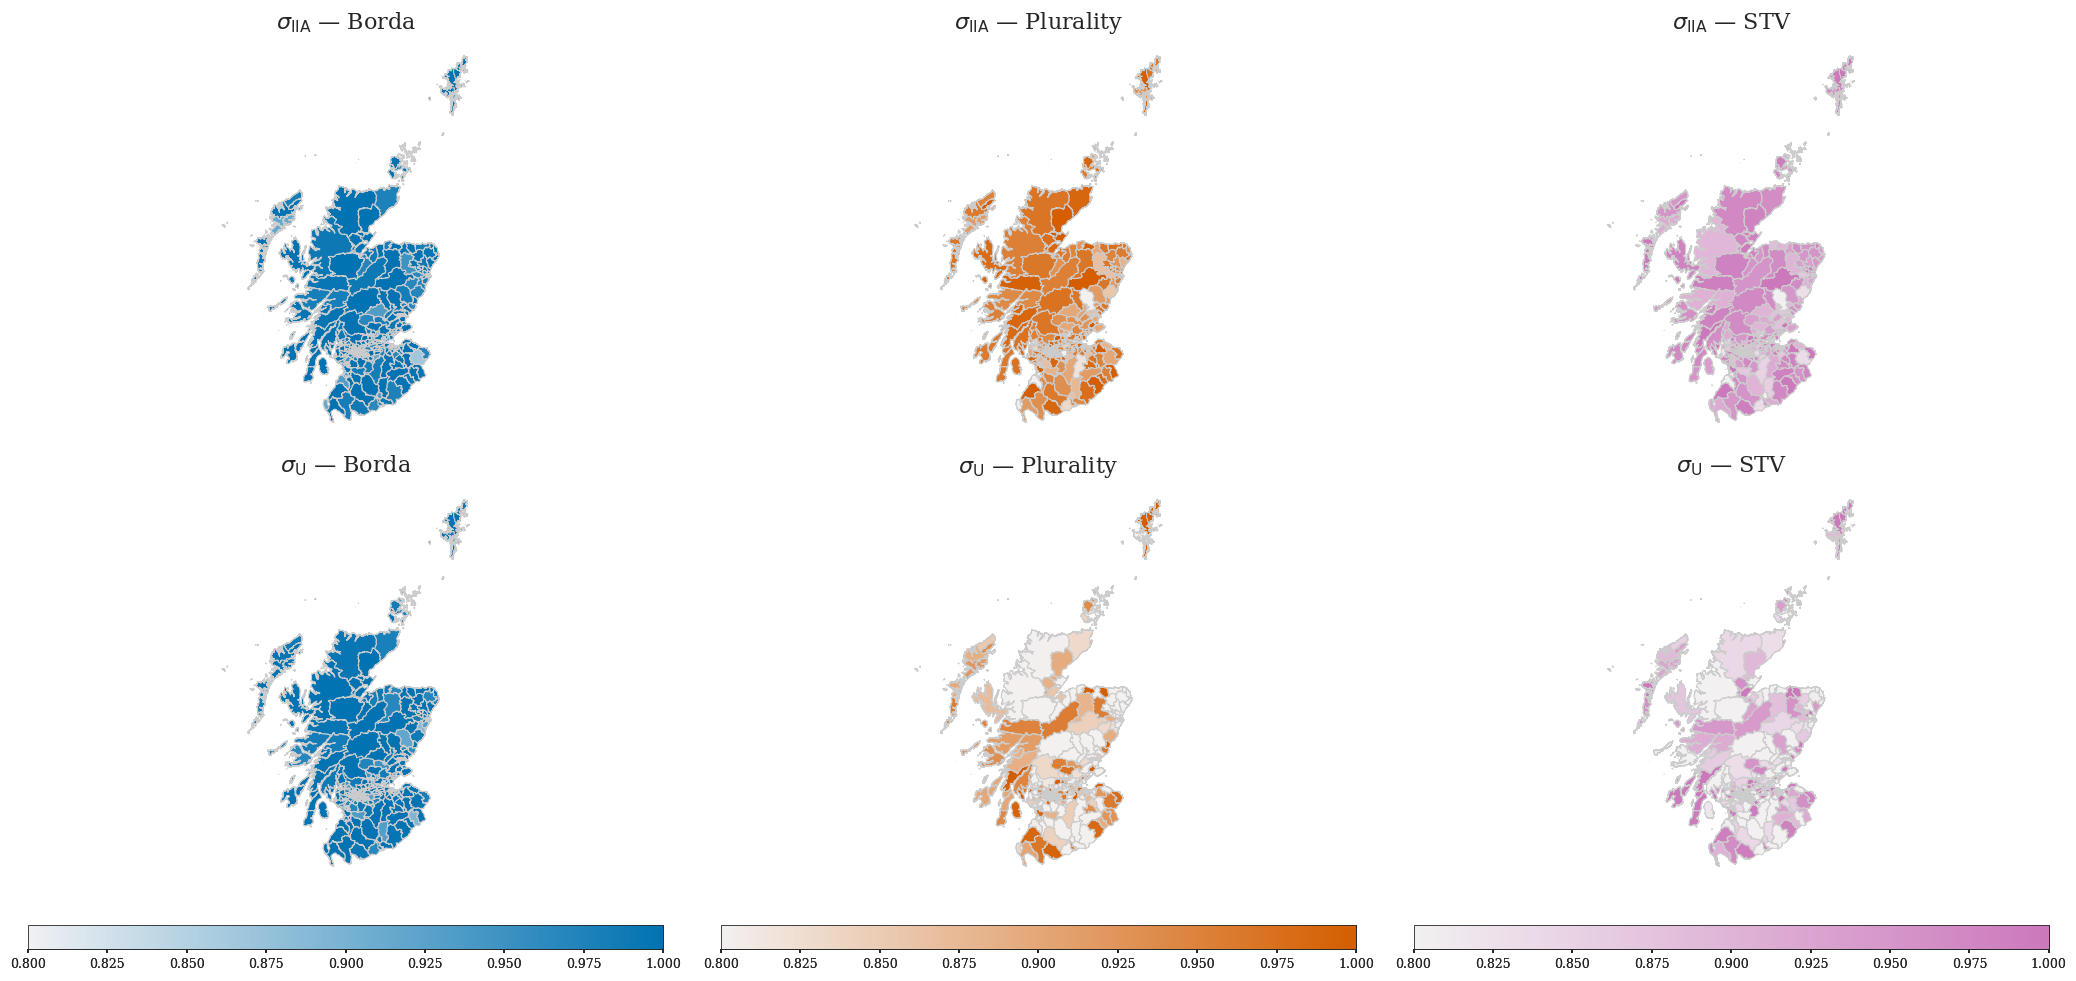

In [ ]:
#code for the generating the heatmap of scottish election of 2012

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Load Data 
wards = gpd.read_file("/Users/name/Downloads/ward/All_Scotland_wards_4th.shp")  #MAKE SURE You provide the path to your shape file.
df = pd.read_csv("/Users/name/Downloads/fairness_scottish_combined_results.csv") # path to your combined dataframe

# Clean & Filter 
df['Council'] = df['Council'].replace({'Na h-Eileanan Siar': 'Na h-Eileanan an Iar'})
df['Ward_No'] = df['Ward'].str.extract(r'(\d+)').astype(float).astype('Int64')
df_2012 = df[df['Year'] == 2012].copy()

# Define Rules and Metrics 
selected_rules = ['Borda', 'Plurality', 'STV']
metrics = [('Sigma_IIA_', r"$\sigma_{\mathrm{IIA}}$"), ('Sigma_UF_', r"$\sigma_{\mathrm{U}}$")]

# Style 
sns.set(style="white", context="notebook", font="serif", font_scale=1.2)
palette = sns.color_palette("colorblind", 5)
rule_color_map = {
    "Borda": palette[0],
    "3−Approval": palette[1],
    "2−Approval": palette[2],
    "Plurality": palette[3],
    "STV": palette[4],
}

# Create Figure Layout 
fig = plt.figure(figsize=(21, 12))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.06])  # Last row for legend
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]
axes = [axes[i*3:(i+1)*3] for i in range(2)]  # reshape to 2x3

# Global fixed scale 
vmin = 0.8
vmax = 1.00

# Plot Maps 
for row, (prefix, metric_label) in enumerate(metrics):
    for col, rule in enumerate(selected_rules):
        ax = axes[row][col]
        colname = f"{prefix}{rule}"
        merged = wards.merge(df_2012, on=['Council', 'Ward_No'], how='left')
        cmap = sns.light_palette(rule_color_map[rule], as_cmap=True)

        merged.plot(
            column=colname,
            cmap=cmap,
            linewidth=0.7,
            edgecolor='0.8',
            legend=False,
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            missing_kwds={
                'color': 'lightgrey',
                'edgecolor': 'white',
                'hatch': '///',
                'label': 'No data'
            }
        )

        ax.set_title(f"{metric_label} — {rule}", fontsize=16)
        ax.axis('off')

        # Add horizontal colorbar per plot (below each map)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar_ax = fig.add_subplot(gs[2, col])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        #cbar.ax.set_xlabel(metric_label, fontsize=11, labelpad=5)
        cbar.ax.tick_params(labelsize=9, length=3)
        cbar.outline.set_linewidth(0.6)

# Final Layout 
plt.tight_layout()
plt.subplots_adjust(bottom=0.18, top=0.94)
#plt.savefig("/Users/name/Downloads/wardmap_neurips_final.pdf", dpi=400, bbox_inches='tight')
plt.show()


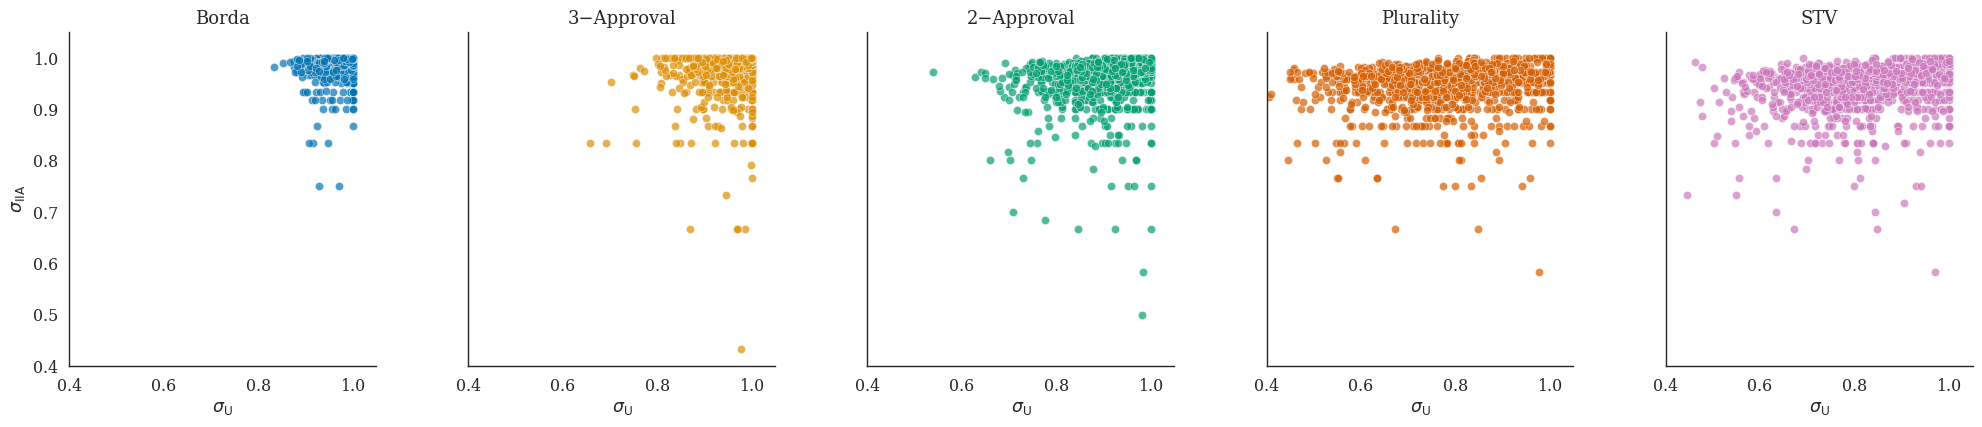

In [ ]:
#Code for scatter plot for voting rules across IIA and UF

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/Users/name/Downloads/fairness_scottish_combined_results.csv") #path for the combined dataframe

# Voting rules and color map
voting_rules = ['Borda', '3−Approval', '2−Approval', 'Plurality', 'STV']
palette = sns.color_palette("colorblind", n_colors=len(voting_rules))
color_map = dict(zip(voting_rules, palette))

# Build combined DataFrame
rows = []
for rule in voting_rules:
    rule_df = pd.DataFrame({
        'Voting Rule': rule,
        'σ_IIA': df[f'Sigma_IIA_{rule.replace("−", "-")}'],
        'σ_UF': df[f'Sigma_UF_{rule.replace("−", "-")}']
    })
    rows.append(rule_df)
df_plot = pd.concat(rows, ignore_index=True)

# Set plot style
sns.set(style="white", context="paper", font="serif", font_scale=1.3)

# Set up subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Plot per voting rule
for ax, rule in zip(axes, voting_rules):
    sub_df = df_plot[df_plot["Voting Rule"] == rule]
    sns.scatterplot(
        data=sub_df,
        x="σ_UF",
        y="σ_IIA",
        color=color_map[rule],
        s=35,
        alpha=0.7,
        ax=ax,
        #label=rule,
        edgecolor='w',
        linewidth=0.4
    )
    ax.set_title(rule, fontsize=13)
    ax.set_xlim(0.4, 1.05)
    ax.set_ylim(0.4, 1.05)
    ax.set_xlabel(r"$\sigma_{\mathrm{U}}$")
    if ax == axes[0]:
        ax.set_ylabel(r"$\sigma_{\mathrm{IIA}}$")
    else:
        ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create horizontal legend *outside* the plot
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=color_map[rule],
                      label=rule, markersize=8) for rule in voting_rules]

# Use bbox_to_anchor to place legend below the entire figure


# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(bottom=0.25, wspace=0.3)
plt.savefig("/Users/name/Downloads/iia_vs_uf_scatter_scottish_plot_1.pdf", dpi=400)
plt.show()

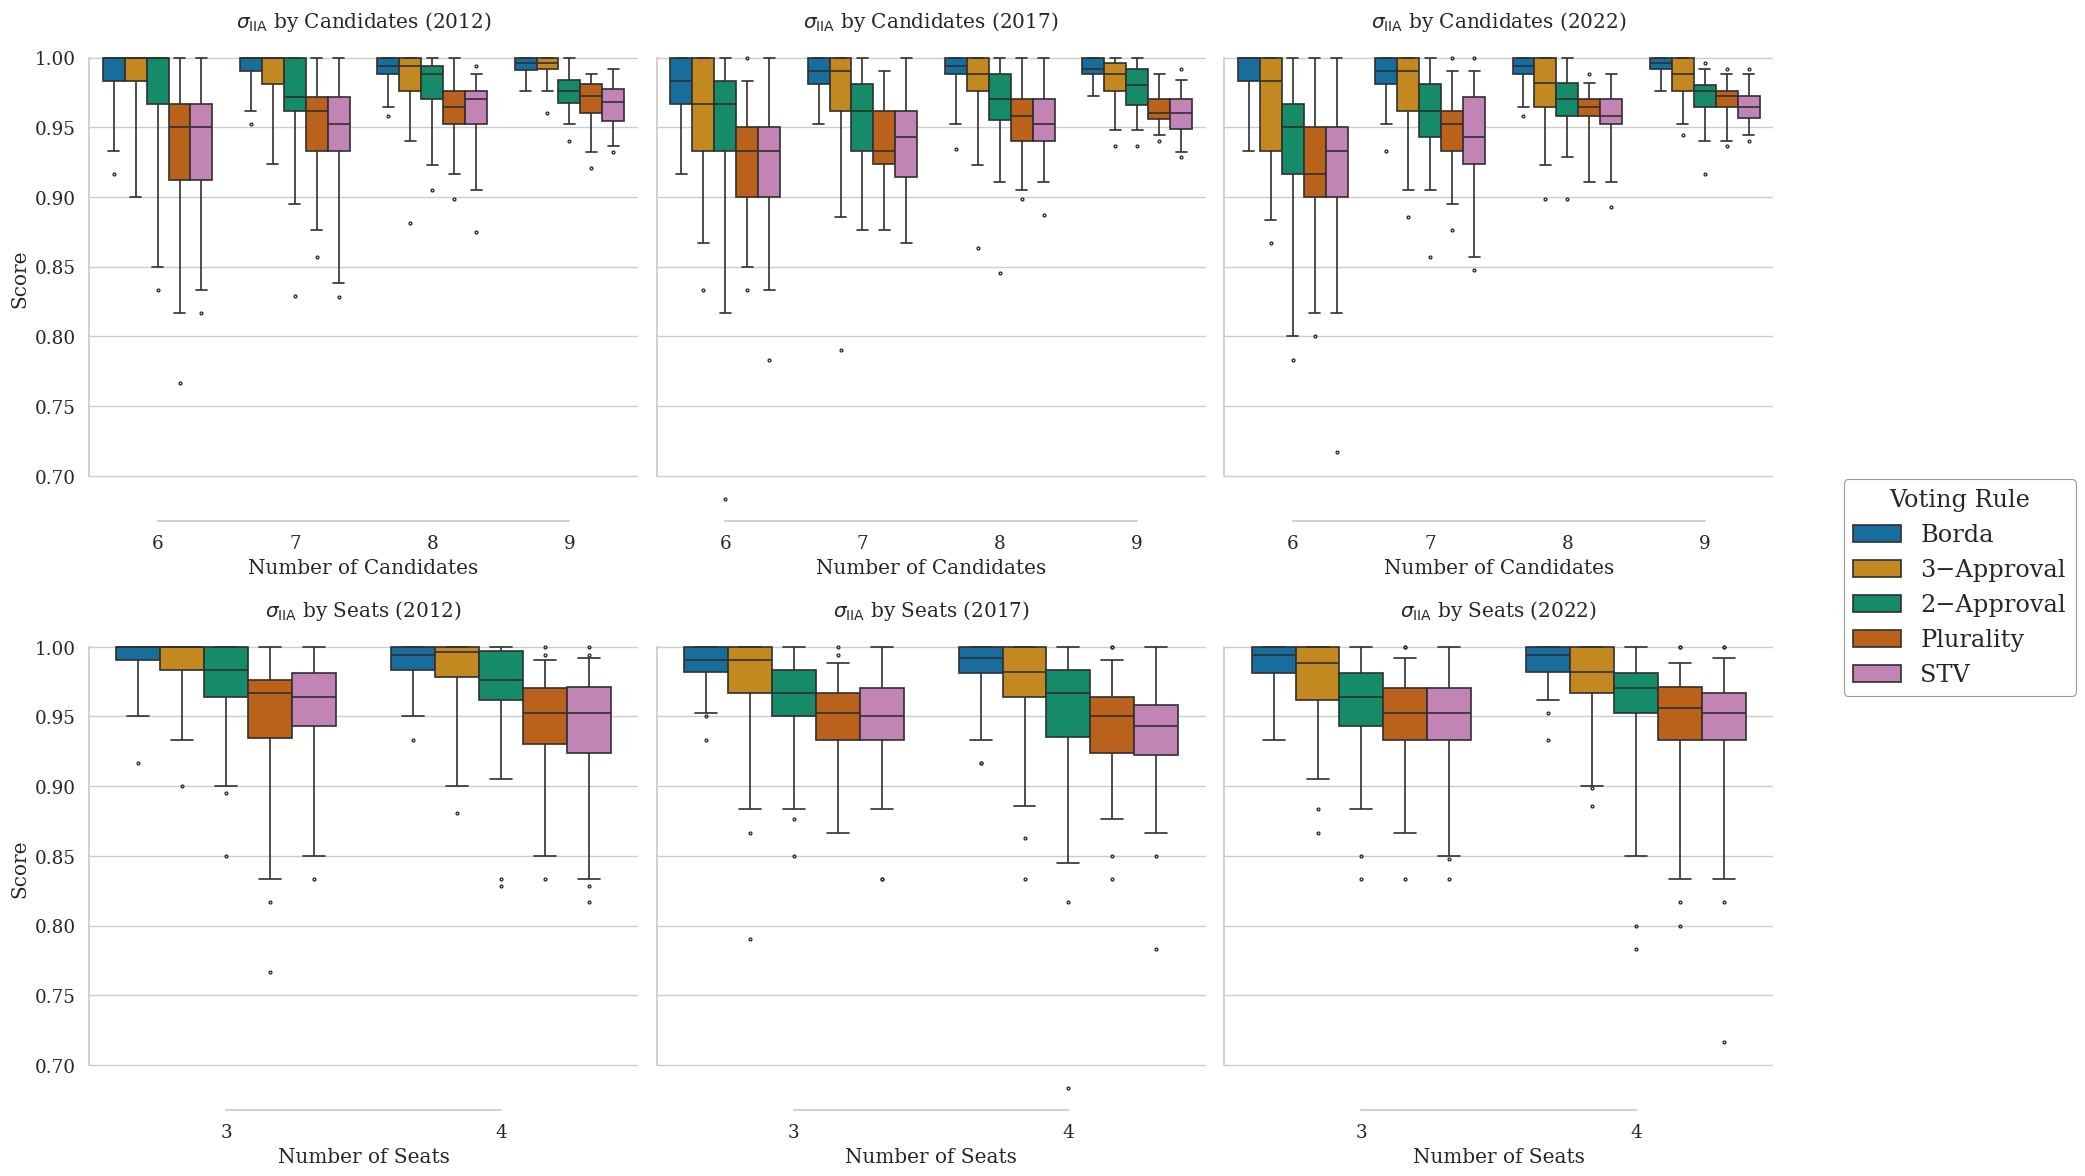

In [ ]:
#Code for additional plots in the supplementary material (change IIA to UF for generating other plots for the UF metric)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/name/Downloads/fairness_scottish_combined_results.csv") #path for the combined dataframe


# Filter dataset
df_subset = df[df["Num_Candidates"].isin([6, 7, 8, 9]) & df["Num_seats"].isin([3, 4])]
df_subset = df_subset[df_subset["Year"].isin([2012, 2017, 2022])]

# Voting rules (Change IIA to UF for the same UF plot)
ordered_rules = ['Borda', '3−Approval', '2−Approval', 'Plurality', 'STV']
iia_col_map = {
    'Sigma_IIA_Borda': 'Borda',
    'Sigma_IIA_3-Approval': '3−Approval',
    'Sigma_IIA_2-Approval': '2−Approval',
    'Sigma_IIA_Plurality': 'Plurality',
    'Sigma_IIA_STV': 'STV'
}

# Helper function to melt by candidates or seats, grouped by year
def melt_df_by(metric_cols, group_col, col_map):
    df_melted = df_subset[metric_cols + [group_col, 'Year']].melt(
        id_vars=[group_col, 'Year'],
        var_name="Voting Rule Raw",
        value_name="Score"
    )
    df_melted["Voting Rule"] = df_melted["Voting Rule Raw"].map(col_map)
    df_melted["X"] = df_melted[group_col]
    return df_melted

# Prepare melted data
df_iia_cands = melt_df_by(list(iia_col_map.keys()), 'Num_Candidates', iia_col_map)
df_iia_seats = melt_df_by(list(iia_col_map.keys()), 'Num_seats', iia_col_map)

df_iia_cands["Group"] = "Candidates"
df_iia_seats["Group"] = "Seats"
df_all = pd.concat([df_iia_cands, df_iia_seats])
df_all["Voting Rule"] = pd.Categorical(df_all["Voting Rule"], categories=ordered_rules, ordered=True)

# Plot aesthetics
sns.set(style="whitegrid", context="notebook", font="serif", font_scale=1.2)

# 2 rows × 3 cols: Top = Candidates, Bottom = Seats
fig, axes = plt.subplots(2, 3, figsize=(21, 12), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.25)

for i, year in enumerate([2012, 2017, 2022]):
    df_cand_y = df_iia_cands[df_iia_cands["Year"] == year]
    df_seat_y = df_iia_seats[df_iia_seats["Year"] == year]

    # Top row (Candidates)
    ax_c = axes[0, i]
    sns.boxplot(
        data=df_cand_y,
        x="X", y="Score", hue="Voting Rule",
        palette="colorblind", linewidth=1.2,
        fliersize=2, dodge=True, whis=[1, 99],
        ax=ax_c
    )
    ax_c.set_title(rf"$\sigma_{{\mathrm{{IIA}}}}$ by Candidates ({year})")
    ax_c.set_xlabel("Number of Candidates")
    ax_c.set_ylabel("Score")
    ax_c.legend_.remove()

    # Bottom row (Seats)
    ax_s = axes[1, i]
    sns.boxplot(
        data=df_seat_y,
        x="X", y="Score", hue="Voting Rule",
        palette="colorblind", linewidth=1.2,
        fliersize=2, dodge=True, whis=[1, 99],
        ax=ax_s
    )
    ax_s.set_title(rf"$\sigma_{{\mathrm{{IIA}}}}$ by Seats ({year})")
    ax_s.set_xlabel("Number of Seats")
    ax_s.set_ylabel("Score")
    ax_s.legend_.remove()

# Shared legend on the right
handles, labels = axes[0, 0].get_legend_handles_labels()
handles_dict = dict(zip(labels, handles))
handles = [handles_dict[rule] for rule in ordered_rules if rule in handles_dict]
labels = [rule for rule in ordered_rules if rule in handles_dict]

legend = fig.legend(
    handles, labels,
    title="Voting Rule",
    loc="center left",
    bbox_to_anchor=(0.88, 0.5),
    bbox_transform=fig.transFigure,
    frameon=True,
    borderaxespad=0.3,
    fontsize='large',
    title_fontsize='large'
)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.8)

# Final touches
sns.despine(trim=True)
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Save or show
#plt.savefig("/Users/name/Downloads/supp_plot1.pdf", dpi=400)
plt.show()



In [2]:
#Code for the synthetic data (Bradley-Terry model, with latent strentght generated from Dirchilet distribution) 

import votekit.ballot_generator as bg
from votekit.pref_interval import PreferenceInterval
from fairness_metric import sigma_IIA, sigma_UF
from Voting_rules import Ranked_Borda, Ranked_Plurality, Ranked_2_Approval, Ranked_3_Approval, Ranked_3_STV
import pandas as pd
import numpy as np
from tqdm import tqdm

import numpy as np
import random


np.random.seed(2025)
random.seed(2025)


def simulate_BT_dirichlet_cases(num_profiles, num_ballots, alpha=3.0, candidate_range=(6, 11)):
    """
    Simulate BT profiles using Dirichlet-distributed preferences under:
      - Uniform case: Dirichlet(alpha)
      - Dominant case: Dirichlet(1/alpha)

    Args:
        num_profiles: number of profiles per candidate size per case
        num_ballots: number of ballots per profile
        alpha: Dirichlet concentration parameter
        candidate_range: tuple (start, end), number of candidates

    Returns:
        pandas DataFrame with metrics
    """
    records = []

    for num_cands in tqdm(range(candidate_range[0], candidate_range[1]), desc="Candidate sizes"):
        candidates = [chr(ord('A') + i) for i in range(num_cands)]

        for case in ["Uniform", "Dominant"]:
            alpha_param = alpha if case == "Uniform" else 1.0 / alpha
            pref_interval = PreferenceInterval.from_dirichlet(candidates=candidates, alpha=alpha_param)

            # Setup BT model
            slate_to_candidates = {"Alpha": candidates}
            pref_intervals_by_bloc = {"Alpha": {"Alpha": pref_interval}}
            bloc_voter_prop = {"Alpha": 1.0}
            cohesion_parameters = {"Alpha": {"Alpha": 1.0}}

            bt_model = bg.slate_BradleyTerry(
                pref_intervals_by_bloc=pref_intervals_by_bloc,
                bloc_voter_prop=bloc_voter_prop,
                slate_to_candidates=slate_to_candidates,
                cohesion_parameters=cohesion_parameters
            )

            for _ in tqdm(range(num_profiles), leave=False, desc=f"{case}, {num_cands} cands"):
                profile = bt_model.generate_profile(num_ballots)

                for rule_name, rule_func in [
                    ("Plurality", Ranked_Plurality),
                    ("Borda", Ranked_Borda),
                    ("2-Approval", Ranked_2_Approval),
                    ("3-Approval", Ranked_3_Approval),
                    ("STV", Ranked_3_STV)
                ]:
                    records.append({
                        "Num_Candidates": num_cands,
                        "Case": case,
                        "Voting_Rule": rule_name,
                        "Sigma_IIA": sigma_IIA(profile, rule_func),
                        "Sigma_UF": float(eval(str(sigma_UF(profile, rule_func)))),
                    })

    return pd.DataFrame(records)

In [ ]:
#Genertae BT model and compute the fairness metrics 

import numpy as np
import random
np.random.seed(2025)
random.seed(2025)

df_sim_2 = simulate_BT_dirichlet_cases(100, 1000, alpha=2.0, candidate_range=(6, 10))  #chamge aloha here to generate profiles with different alpha
df_sim_3 = simulate_BT_dirichlet_cases(100, 1000, alpha=3.0, candidate_range=(6, 10))  #chamge aloha here to generate profiles with different alpha


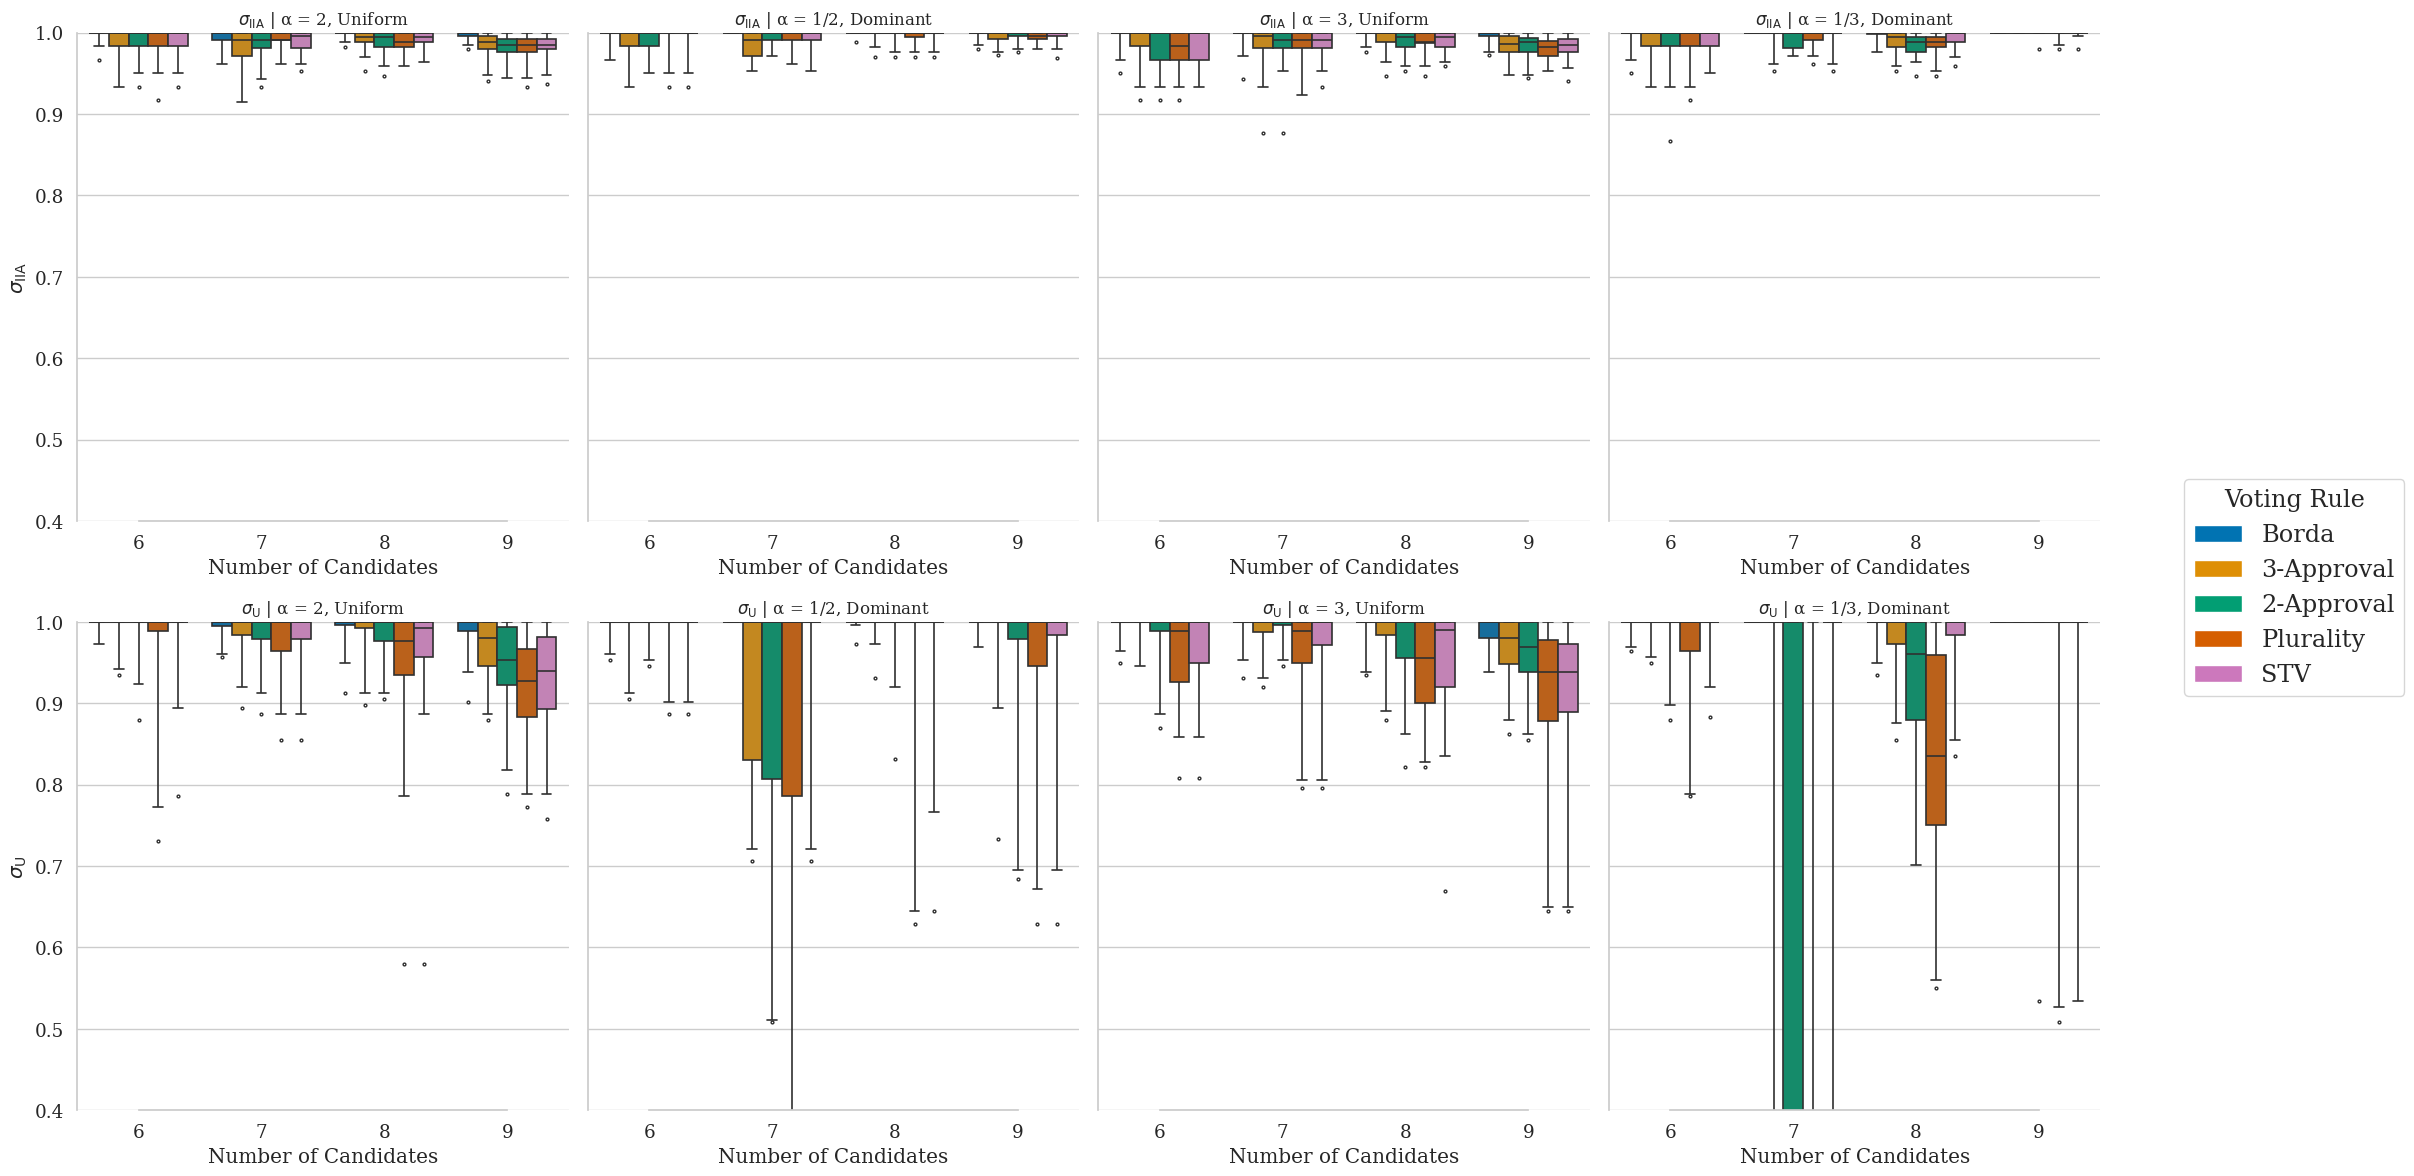

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch



# Annotate with alpha parameter 
df_sim_2['Alpha'] = 2
df_sim_3['Alpha'] = 3
df_all = pd.concat([df_sim_2, df_sim_3], ignore_index=True)

# === Define Voting Rule Order and Color Map ===
ordered_rules = ['Borda', '3-Approval', '2-Approval', 'Plurality', 'STV']
palette = sns.color_palette("colorblind", 5)
rule_color_map = dict(zip(ordered_rules, palette))
df_all["Voting_Rule"] = pd.Categorical(df_all["Voting_Rule"], categories=ordered_rules, ordered=True)

# Setup Plotting Grid 
sns.set(style="whitegrid", context="notebook", font="serif", font_scale=1.2)
fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharey='row')
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Plot Structure
metrics = [("Sigma_IIA", r"$\sigma_{\mathrm{IIA}}$"), ("Sigma_UF", r"$\sigma_{\mathrm{U}}$")]
alphas = [2, 3]
cases = ['Uniform', 'Dominant']

# Create 8 Plots 
for row, (metric, ylabel) in enumerate(metrics):
    for col, (alpha, case) in enumerate([(a, c) for a in alphas for c in cases]):
        ax = axes[row, col]
        subset = df_all[(df_all['Alpha'] == alpha) & (df_all['Case'] == case)]

        sns.boxplot(
            data=subset,
            x="Num_Candidates",
            y=metric,
            hue="Voting_Rule",
            hue_order=ordered_rules,
            palette=rule_color_map,
            ax=ax,
            linewidth=1.2,
            fliersize=2,
            whis=[1, 99],
            dodge=True
            
        )

        ax.set_ylim(0.4,1)

        # Show correct α value depending on case
        alpha_str = f"{alpha}" if case == "Uniform" else f"1/{alpha}"
        ax.set_title(f"{ylabel} | α = {alpha_str}, {case}", fontsize=12)

        ax.set_xlabel("Number of Candidates")
        if col == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")
        ax.legend_.remove()

# External Legend 
legend_patches = [Patch(facecolor=rule_color_map[r], label=r) for r in ordered_rules]
fig.legend(
    handles=legend_patches,
    title="Voting Rule",
    loc="center left",
    bbox_to_anchor=(0.91, 0.5),
    frameon=True,
    fontsize='large',
    title_fontsize='large'
)

# Final Layout 
sns.despine(trim=True)
plt.tight_layout()
plt.subplots_adjust(right=0.88)

# Save Output
#plt.savefig("/Users/name/Downloads/synthetic_plot_main_4_5.pdf", dpi=400)
plt.show()